In [1]:
import os, json
import pandas as pd
from pandarallel import pandarallel
import json 
import plotly.express as px
from IPython.display import Image
from unidecode import unidecode
import regex as re
re.DEFAULT_VERSION = re.VERSION1

import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein
import spacy
import numpy as np
import pickle

2023-01-23 15:20:37.538231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 15:20:39.580097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-23 15:20:39.580237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-23 15:20:39.580250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
#TO REMOVE ARTICLE CONTAINING : 
{['RENSEIGNEMENT','MONDAIN'], ['TEMPERATURE','TEMPÉRATURE'], 
 ['JOURNEE','JOURNÉE'], ['MARIAGES'], ['DEUIL'], ['LA BOURSE'], ['THÉÂTRE','SPECTACLE','OPERA','OPÉRA','THEATRE','COURRIER'],
 ['SOMMAIRE'], ['COURSES'],[' MENU ',' VINS ']}

['deuil', 'mariages','renseignements','latempérature','spectacles','sommaire',
 'feuilleton','labourse','théâtre','theatre','concert','ventes','offres']

#split par sequence de majuscule :
#findall occurence, remove ceux qui sont juste des chiffres romain 
#avec potentiellement de la ponctuation : XXXVI XVI, XVIII. IV' 
# replace les autres avec un marqueurs pour le spliting
headlineRegex = '\p{Lu}(?:.?\p{Lu}.?){2,}\p{Lu}{2}\W*(?=\s\p{Lu}?[^\p{Lu}]{,2}\p{Ll})'
headlineCompiled = regex.compile(headlineRegex)

#remove les sequences noisy : regex pour séquence de mot de 1 ou 2 caractere entrecoupé de 

#split comment avant + sequence de Majuscule qui ne sont pas des chiffres romains et numeroté tous les paragraphs garder (avec ratio >0.6 par eg) 
#pour chaque page (0 -n paragraphe dans la page x)

#checker chiffre romain : extraire potentiel chiffre romain [MXCVID] et verifier avec regex:
romanRegex = '(?=[MDCLXVI])M{0,3}(?:C[DM]|DC{0,3}|C{1,3})?(?:X[LC]|LX{0,3}|X{1,3})?(?:I[XV]|VI{0,3}|I{1,3})?'

#regarder distriution des logueurs de text après split par headlines

# on garde TOUS LES TEXTES, sauf les trop noisy, pour train word2vec, les bigrams et le correcteur

# on vire les articles avec les mots clefs par dessus en majuscule et les dernières pages

# on clean avec le corrector

# on revire les articles avec les mots clefs par dessus en majuscule (o k ou)

# on finalClean

# on rerevire les articles avec les mots clefs par dessus en majuscule (o k ou)? 

#Faire un graph de la difference de la moyenne de char par année avant et après correction



In [2]:
## TO DO:
## RUN CORRECTION OVER THE NON FILTERED PARAGRAPH
## peut etre que si len >25 et si on est sur les bonnes pages

# Data Cleaning 

In [2]:

# Class for cleaning such that the regex don't have to be compiled each time
class TextCleaner:
    def __init__(self):
        
        essentialNonAlpha = re.escape("!',-.:;?\n")
        self.vowel = 'aeiouyÿŷáàâéèêìíîïòóôöüûùú'
        self.consonnant = '[\p{L}--['+self.vowel+self.vowel.upper()+']]'
        self.vowel = '['+self.vowel+self.vowel.upper()+']'
        #regex to keep only some essential punctation and alphanumeric character
        self.noisyChar = re.compile('[^\p{L}\d'+essentialNonAlpha+']+')
        #regex to remove sequence of random character 
        self.noisySequence = re.compile('(?<=\W)\W*(?:(?:.{1,2}|'+
                                        self.consonnant + '{2,}|' + 
                                        self.vowel + '{2,})\W+){4,}.{1,2}\s')
        self.noisyPunctSequence = re.compile(f'(?<=[{essentialNonAlpha}\$])\W+')
        
        
        #Regex for splitting text into "articles"
        self.splitPatterns = re.compile('(?:(?<=[!?.])(?:\s?.){0,4}\n(?:\s?.){0,4}(?=\p{Lu}))')
        
        # regex for headlines detection                              
        headlineRegex = '^.{,3}(?:[\p{Lu}\W]?.?\p{Lu}.?[\p{Lu}\W]?)+\p{Lu}.?(?:\p{Lu}[\p{Lu}\W]*.?[\p{Lu}\W]*)+(?=\p{Lu}\p{Ll})'
        self.headlineCompiled = re.compile(headlineRegex)
        
        # regex for roman number verification
        romanRegex = ('(?=[MDCLXVI])M{0,3}(?:C[DM]|DC{0,3}|C{1,3})?'+
                          '(?:X[LC]|LX{0,3}|X{1,3})?(?:I[XV]|VI{0,3}|I{1,3})?')

        self.romanCompiled = re.compile(romanRegex)
        
        self.nonAlphaChar = re.compile('[^\p{L}]')
        self.nonUpperAlphaChar = re.compile('[^\p{Lu}]')
        
        
    def getOCRconfidence(self, confidence):
        return float(confidence[0].split()[-1].replace(',','.'))
    
    def getAlphaChar(self, text):
        return self.nonAlphaChar.sub('',unidecode(text))
        
    def getAlphaRatio(self, text):
        textLen = len(text)
        if textLen:
            alpha = re.sub('[^\p{L} ]','',text)
            nonLowerAlpha = re.sub('[^\p{Lu} ]','',alpha)

            return (len(alpha)/textLen, len(nonLowerAlpha)/textLen, textLen)
        else:
            return (0,0,0)
        
       
    def isRomanNumber(self, headline):
        romanNumberLetter = ' '.join(re.findall('[LXIVCDM]{2,}',headline.upper()))
        headlineWoPunctLen = len(' '.join(re.findall('\w{2,}',headline)))
        if (headlineWoPunctLen>0) and len(romanNumberLetter)/headlineWoPunctLen>0.7:
            match = self.romanCompiled.fullmatch(romanNumberLetter)
            return False if (match is None) else True
        else:
            return False
        
                                        
    def splitParagraphs(self, page):
        headlines = self.headlineCompiled.findall(page)
        headlines = [headline for headline in headlines if not self.isRomanNumber(headline)]
        for headline in headlines:
            page = page.replace(headline, '__SPLIT__'+headline)
        page = page.replace('\n','__SPLIT__')
        paragraphs = [(n,paragraph,self.getAlphaRatio(paragraph)) for n,paragraph 
                      in enumerate(page.split('__SPLIT__')) if len(paragraph)>0]
        
        return paragraphs
        
        
    def cleanParagraph(self, text):
        textLen = len(text)
        text = ' '+' '.join(self.noisyChar.sub(' ', text).split()) + ' '
        # transform "..." sequence to "$" to preserve from next steps
        text = re.sub('(?<=[\w\s])\.{3}\s','$ ',text)
        text = self.noisySequence.sub(' ',text)
        text = self.noisyPunctSequence.sub(' ',text)
        ### get "..." back
        text = text.replace('$ ','... ')
        text = ' '.join(text.split())
        cleanRatio = len(text)/textLen if textLen>0 else 0
        return cleanRatio, text
    
            
    
    
    def filterPage(self, row):
        nPages = row['nPages']
        if nPages == 4 :
            return row['pageNum']<3 
        elif (nPages == 6):
            return row['pageNum']<4 
        elif (nPages == 8):
            return row['pageNum']<6 
        else : 
            return False
        
    
    def dropLastPages(self, textDf):
        textDf = textDf[textDf.apply(lambda row : self.filterPage(row), axis=1)]
        return textDf
    
    
    def getHeadlines(self, text, wMax=20): 
        if text:
            text = text.split()
            headlines = [self.getAlphaChar(''.join(text[:i])).lower() for i in range(1,wMax+1)]
            headlines = [headline for headline in headlines if (len(headline)>=4)]
            return (set(headlines), 
                    headlines[-1] if len(headlines)>0 else '',
                    self.getAlphaChar(''.join(text)).lower())
        else: 
            return ({},'','')
        
    
    def hasHeadline(self, row, headlines):
        return (len(row['headlines'] & headlines)>0) or (len(self.headlineCompiled.findall(row['content']))>0)
    
    def isHeadline(self, row, headlines):
        length = len(row['alphaContent'])
        return ((length<60 & self.hasHeadline( row, headlines))| 
                (len(self.nonUpperAlphaChar.sub('',row['content']))/length >0.5)) if (length>0) else True
    
    
    def setAlphaContent(self, alphaContent):
        self.alphaContent = alphaContent
    
    def countsHeadline(self, headline): 
        return (headline, sum(headline in aContent for aContent in self.alphaContent))
        
    
    def mergeParagraphs(self,df, headlines): 
        articles = []
        article = {}
        headline= ''
        headlineInd = -1
        newArticle = lambda row : {'date':row['date'],
                                   'pageNum':row['pageNum'],
                                   'paragraphNum':[row['paragraphNum']],
                                   'content':row['content'],
                                   'headline': ''}
            
        for row in df:
            if self.isHeadline(row,headlines):
                headline = row['content']
                headlineInd = row['paragraphNum']
                if len(article)>0:
                    article['paragraphNum'] = '-'.join(str(num) for num in article['paragraphNum'])
                    articles.append(article)
                    article = {}
            elif len(article) == 0:
                article = newArticle(row)
                if row['paragraphNum']-headlineInd in [1,2]:
                    article['headline'] = headline
                headline = ''
            elif (((len(set(article['content'][-5:])&{'.','?','!'})>0) and 
                   (len(self.getAlphaChar(row['content'][:3]))>0)) or
                  self.hasHeadline(row,headlines) or 
                  (row['paragraphNum']-article.get('paragraphNum',[-1])[-1] != 1)):
                article['paragraphNum'] = '-'.join(str(num) for num in article['paragraphNum'])
                articles.append(article)
                article = newArticle(row)
                
            else : 
                article['paragraphNum'].append(row['paragraphNum'])
                article['content'] += ' ' + row['content']
                
        mergedDf = pd.DataFrame(articles)
        mergedDf.content= mergedDf.content.str.split().apply(' '.join)
        return mergedDf
    
    
    def setHeadlines(self,headlines):
        self.headlines = headlines
    
    def removeHeadline(self, text, wMax=20):
        text = text.split()
        bestHeadIndex = 0
        headIndex=1
        headlines = [self.getAlphaChar(''.join(text[:1])).lower()]
        while ((len(headlines[-1])<4) or  (headlines[-1] in self.headlines)) and (wMax>=headIndex):
            headIndex+=1
            headlines.append(self.getAlphaChar(''.join(text[:headIndex])).lower())
            if self.headlines.get(headlines[-1],False): 
                bestHeadIndex=headIndex
                
        headline = ' '.join(text[:bestHeadIndex])
        content = ' '.join(text[bestHeadIndex:])
        
        moreHeadline = self.headlineCompiled.findall(content)
        if len(moreHeadline) > 0:
            if not self.isRomanNumber(moreHeadline[0]):
                headline += ' ' + moreHeadline[0]
            content = content.replace(moreHeadline[0], '',1)
            
        return headline,content
        
        
        
    
    

## Loading the json files

In [6]:
text = []
for root, dirs, files in os.walk('data/le_figaro'):
    for name in files:
        if name.endswith((".json")) and 'le_figaro' not in name:
            with open(os.path.join(root, name)) as f: 
                text.append(json.load(f))

In [7]:
t = time.time()
textDf = pd.DataFrame(text)
textCleaner = TextCleaner()
gc.collect()
textDf['date'] = textDf.date.apply(lambda x : x[0]) 
textDf['year'] = textDf.date.apply(lambda x : x.split('-')[0]) 
textDf['OCR confidence'] = textDf['format'].apply(textCleaner.getOCRconfidence)
textDf['nPages'] = textDf.contentAsText.apply(len)
textDf = textDf[['contentAsText','date','OCR confidence','nPages']].rename(columns = {'contentAsText':'pages'})
#del text
gc.collect()
print(time.time()-t)

0.6906130313873291


In [10]:
textDf['OCR confidence'].mean()

0.5749198444199642

## Visualization of number of page by issue

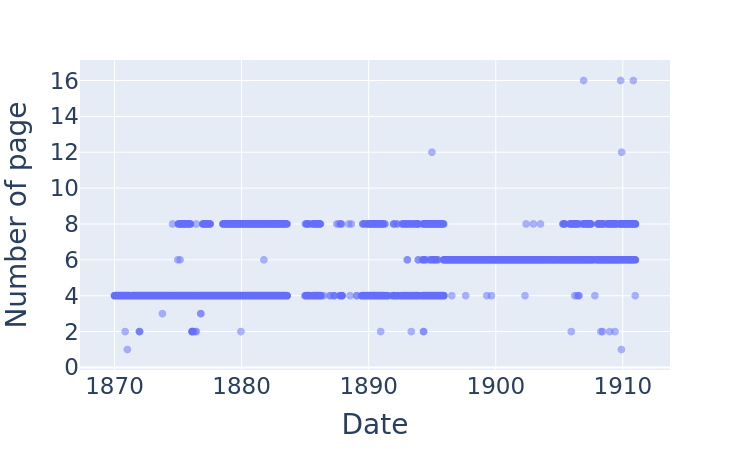

In [33]:
img = px.scatter(textDf, x = 'date', y = 'nPages')
img.update_traces(marker={'size': 8,'opacity' :0.5})
img.update_layout(
    #title="Plot Title",
    xaxis_title="Date",
    yaxis_title="Number of page",
    font_size = 23
    #legend_title="Legend Title",
)
Image(img.to_image(format="png", width=750, height=450))

## Split issues by pages

In [8]:
'''t = time.time()
textCleaner = TextCleaner()
textDf.pages = textDf.pages.apply(lambda pages : [(n,page) for n,page in enumerate(pages)])
textDf = textDf[textDf.pages.apply(len)>0].explode('pages').reset_index().drop(columns ='index')
textDf['pageNum'] = textDf['pages'].apply(lambda page_content : page_content[0])
textDf['pages'] = textDf['pages'].apply(lambda page_content : page_content[1])
textDf = textDf[textDf.pages.apply(len)>0].copy()
#textDf['content'] = textDf.pages.apply(textCleaner.splitParagraphs)
#textDf = textDf[textDf.content.apply(len)>0].drop(columns = ['pages']).copy()
print(time.time() -t)'''

0.18413662910461426


In [19]:
t = time.time()
pandarallel.initialize(nb_workers = 10, progress_bar=True)
textCleaner = TextCleaner()
enumContent =  lambda contents : [(n,content) for n,content in enumerate(contents)]
textDf.pages = textDf.pages.apply(enumContent)
textDf = textDf[textDf.pages.apply(len)>0].explode('pages').reset_index()
textDf['pageNum'], textDf['content'] = zip(*textDf['pages'])
textDf = textDf.drop(columns =['index','pages']).copy()
gc.collect()
textDf['content'] = textDf.content.str.split('\n').apply(enumContent)
textDf = textDf[textDf['content'].apply(len)>0].explode('content')
print(time.time() -t)
textDf['paragraphNum'],textDf['content']=zip(*textDf.content)
(textDf['AlphaRatio'],
 textDf['nonLowerAlphaRatio'],
 textDf['length']) = zip(*textDf.content.parallel_apply(textCleaner.getAlphaRatio))
textDf['cleanRatio'],textDf['cleanText']=zip(*textDf.content.parallel_apply(textCleaner.cleanParagraph))
gc.collect()
print(time.time() -t)

2896.3470137119293


In [29]:
textDf.drop(columns = ['OCR confidence','lenLabel']).to_csv('data/le_figaro_full.csv',index=False)

In [3]:
textDf = pd.read_csv('data/le_figaro_full.csv')

## Plot noise density

In [118]:
'''gc.collect()
le_figaro_paragraph = textDf.copy().explode('content')
le_figaro_paragraph = le_figaro_paragraph[~le_figaro_paragraph.content.isna()]
(le_figaro_paragraph['paragraphNum'], 
 le_figaro_paragraph['content'],
 le_figaro_paragraph['alphaRatio']) = zip(*le_figaro_paragraph.content)
le_figaro_paragraph.to_csv('data/le_figaro_paragraph.csv',index=False)'''


In [21]:
def label(x):
    if x <10 :
        return 'length<10'
    if x <25 :
        return '10<=length<25'
    if x <50 :
        return '25<=length<50'
    elif x <100: 
        return '50<=length<100'
    elif x <500:
        return '100<=length<500'
    elif x <1000:
        return '500<=length<1000'
    else:
        return '1000<=length'
'''
le_figaro_paragraph['len'] = le_figaro_paragraph['content'].apply(len)
le_figaro_paragraph['lenLabel'] = le_figaro_paragraph['len'].apply(label)'''

textDf['lenLabel'] = textDf['length'].apply(label)

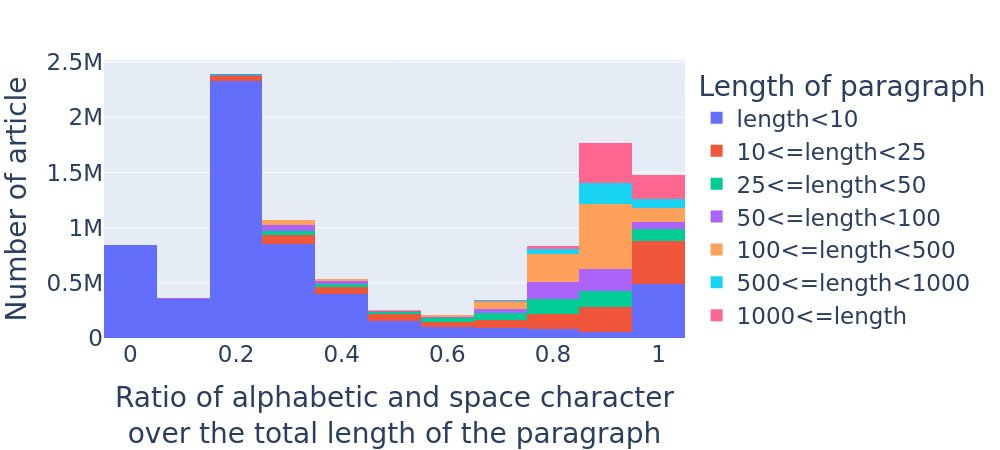

In [31]:
img = px.histogram(textDf.sort_values('length'), x = 'AlphaRatio', color='lenLabel', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of alphabetic and space character<br>over the total length of the paragraph",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of paragraph",
)
Image(img.to_image(format="png", width=1000, height=450))

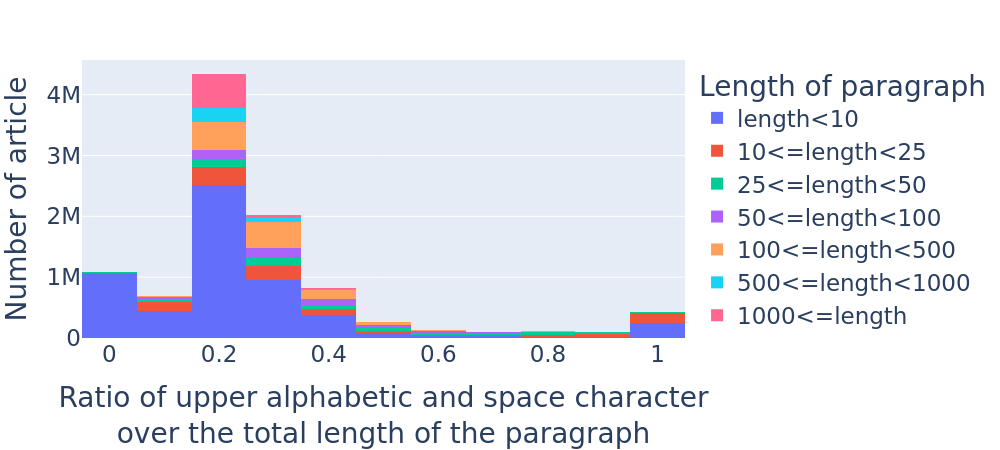

In [32]:
img = px.histogram(textDf.sort_values('length'), x = 'nonLowerAlphaRatio', color='lenLabel', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of upper alphabetic and space character<br>over the total length of the paragraph",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of paragraph",
)
Image(img.to_image(format="png", width=1000, height=450))

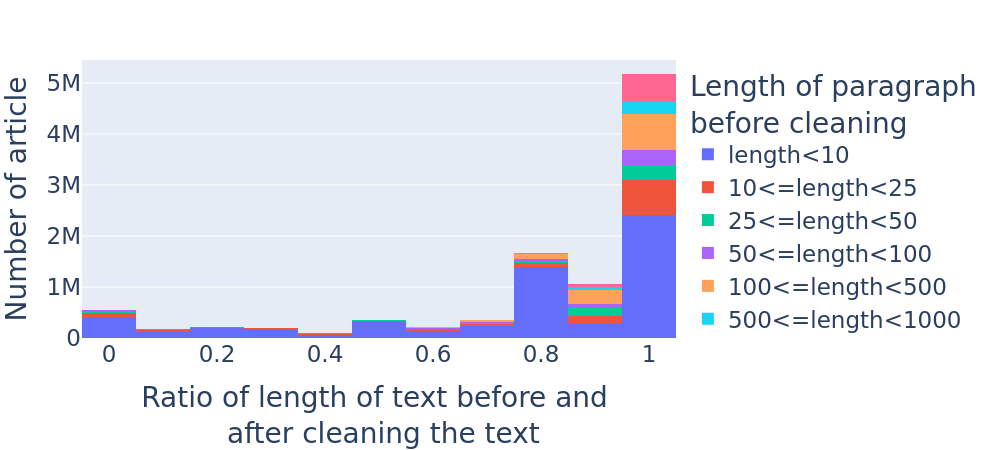

In [33]:
img = px.histogram(textDf.sort_values('length'), x = 'cleanRatio', color='lenLabel', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of length of text before and <br> after cleaning the text ",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of paragraph <br>before cleaning",
)
Image(img.to_image(format="png", width=1000, height=450))

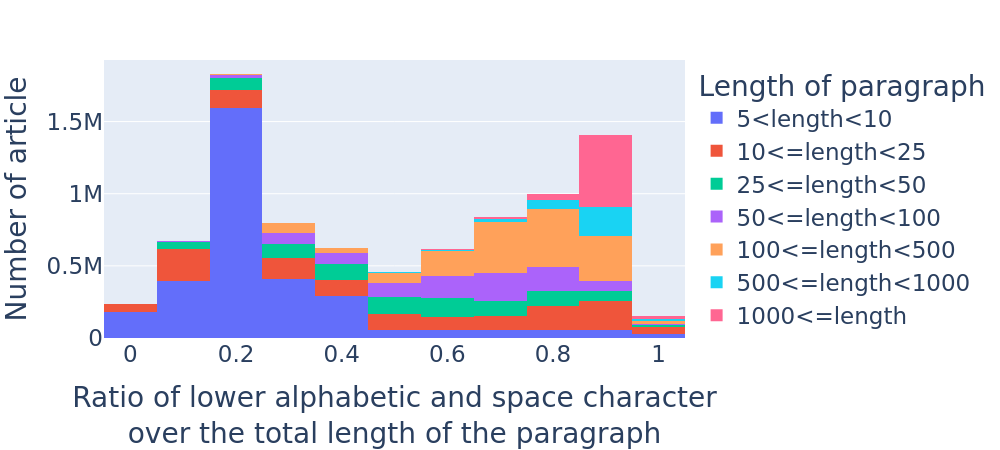

In [120]:
img = px.histogram(le_figaro_paragraph[(le_figaro_paragraph['len'] > 5)].sort_values('len'), x = 'alphaRatio', color='lenLabel', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of lower alphabetic and space character<br>over the total length of the paragraph",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of paragraph",
)
del le_figaro_paragraph
Image(img.to_image(format="png", width=1000, height=450))

## Remove noisy part of the corpus and clean text by removing unwanted character introduced by OCR

In [121]:
'''t = time.time()
gc.collect()
textDf.content = textDf.content.apply(textCleaner.filterParagraphs)
textDf = textDf.drop(columns=['OCR confidence']).explode('content')
textDf = textDf[~textDf.content.isna()]
textDf['contentID'], textDf['content'] = zip(*textDf.content)
textDf = textDf[~textDf.content.isna()].reset_index().drop(columns='index')
textDf = textDf[textDf.content.apply(len)>25].copy()
print(len(textDf))
print(time.time()-t)'''

923.4352130889893


In [13]:
textDf = textDf[(textDf.AlphaRatio>0.6) & (textDf.content.apply(len)*textDf.AlphaRatio>5)]
textDf = textDf[['date', 'pageNum','paragraphNum', 'cleanText', 'AlphaRatio', 'nPages']]
textDf = textDf.rename(columns={'cleanText':'content'})

In [14]:
gc.collect()
textDf.to_csv('data/le_figaro_filtered.csv',index=False)

# Word2vec model for recurrent OCR error correction

## Training the model

In [94]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss
        if (self.epoch)%5 ==0:
            print('saving model')
            model.save(f"models/embeddings/wvstep/Word2Vec_OCR_correction_step{self.epoch}.model")

In [86]:
textDf = pd.read_csv('data/le_figaro_filtered.csv')

In [87]:
textDf

,date,pageNum,paragraphNum,content,AlphaRatio,nPages
0,1900-10-21,0,0,46' Année 3 e Série N 284,0.666667,6
1,1900-10-21,0,1,Le Numéro SEME SEINE-ET-OISE : is centimes . D...,0.868421,6
2,1900-10-21,0,2,Dimanche 21 Octobre 1900,0.750000,6
3,1900-10-21,0,3,Directeurs-rGêranfs P.DE RODAYS J A. PÉRIVIEB ...,0.939024,6
4,1900-10-21,0,4,H. DE VILLEMESSANT Fondateur,0.964286,6
...,...,...,...,...,...,...
3969695,1907-05-27,5,128,"PHARMACIE NORMALE, 19,r.Drouot,Paris.",0.810811,6
3969696,1907-05-27,5,129,TYROL GLACIERS.,0.933333,6
3969697,1907-05-27,5,130,Lé plus charmant pays des Alpes. Merveilles de...,0.855856,6
3969698,1907-05-27,5,131,âSTHRSEÊSStCSEESPIS Imprimeur-Gérant QUIN TA.R...,0.915789,6


In [62]:
t = time.time()
# set space between word and punctuation
textDf['raw_article'] = textDf.content.str.replace('(?<=\w)(?=[\!,\.:;\?]\W)',' ',regex=True)
textDf['raw_article'] = textDf.raw_article.str.replace('(?<=\W[\!,\.:;\?])(?=\w)',' ',regex=True)

# uniformize digits
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('\d','$',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>50].copy()

print(len(textDf))
print(time.time()-t)
t = time.time()

raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=4, threshold=7.5)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
print(time.time()-t)


1150.2514336109161


In [63]:
textDf['nGram'] = raw_articles
textDf['nGram'] = textDf['nGram'].apply(' '.join)
textDf.to_csv('data/le_figaro_filtered_ngram.csv',index=False)

In [ ]:
corLexique = textDf.raw_article.str.split().explode().value_counts()
corLexique = corLexique[corLexique>25]
corLexique = corLexique.to_dict()

errLexique = textDf.nGram.str.split().explode().value_counts()
errLexique = errLexique[errLexique>4]
errLexique = errLexique.to_dict()

In [93]:
#textDf = pd.read_csv('data/le_figaro_prefiltered.csv')
#raw_articles = textDf.nGram.str.split().tolist()

In [95]:
cb = callback()
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 128,
                 window = 5,
                 min_count = 4,
                 sample = 8e-4,
                 sg = 1,
                 hs=1,
                 #negative = 20,
                 #ns_exponent=0.1,
                 epochs = 15,
                 workers = 20,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_OCR_correctionbis.model") #best so far

Loss after epoch 0: 98509240.0
Loss after epoch 1: 35708488.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
saving model
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
saving model
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
saving model


In [ ]:
model = Word2Vec.load("models/embeddings/Word2Vec_OCR_correction.model")

In [263]:
f = errLexique.get('de')/(sum(errLexique[k] for k in errLexique))
s = 1e-3

np.sqrt((f/s) + 1)*s/f


0.15215565334053505

## Make the error-correction pair 

In [3]:
class Corrector():
    
    def __init__(self,model=False,corLexique=None,errLexique=None):
        self.model = model
        if  corLexique and errLexique:
            self.corLexique = corLexique
            self.errLexique = errLexique
            self.typosPair = {}
            self.segmentationsPair = {}
            self.fusionsPair = {}
        else:
            self.loadData()
        
        self.typoRatio = 15
        self.segRatio = 15
        self.lineBreakPattern = re.compile('[^\p{L}]?\-[^\p{L}]?')
        self.toSegmentAgain = None
        
        #regex for misplaced punctuation character
        self.stickingPunct = re.compile('(?:(?<=[\!\?\.])(?=\p{Lu}))')
        self.noisyStickingPunct = re.compile('[\!\?\.][^\p{L}]*(?=\p{Ll})')
        
    
    
    def makeCorrectionPair(self, word, wordFreq):
        typos = []
        segmentations = []
        fusions = []
        wordLen = len(word)
        errWordFreq = self.errLexique.get(word,False) # for fusion
        
        if (wordLen>1) and errWordFreq:
            
            for n, (simWord, sim) in enumerate(self.model.wv.most_similar(word,topn = 100)):
                
                simWordLen = len(simWord)
                diffLen = simWordLen-wordLen
                simWordFreq = self.errLexique.get(simWord,False)
                
                if (abs(diffLen) in [0,1,2]) and simWordFreq:
                    simWordFreq = max(self.corLexique.get(simWord,0), simWordFreq)
                    
                    if ((wordLen>2) and  (abs(diffLen) in [0,1]) and (sim>0.6) and 
                        (n < 70) and (simWordFreq*self.typoRatio<wordFreq)):
                        
                        if ((word[1:].lower() != simWord[1:].lower()) and 
                            ((word[-1] ==simWord[-1] if (word[-1] in '?.!,') else True)
                             if (not ((word[-1] in '?.!,')^(simWord[-1] in '?.!,'))) 
                             else False )):
                            dist = levenshtein(word, simWord, 2)
                            
                            if (diffLen == 0) and (dist == 1):
                                typos.append((simWord.replace('_',' '),sim))
                                
                            elif ((simWordLen>3) and (sim>0.65) and (dist<3) and 
                                  (simWord.replace('_','').lower() != word.lower()) and
                                  (simWordFreq*max((self.typoRatio*30)/simWordLen,self.typoRatio*4)<wordFreq)):
                                typos.append((simWord.replace('_',' '),sim))
                                
                    if (simWordFreq*max(self.segRatio/simWordLen,2)<wordFreq) and (diffLen>0):
                        
                        if simWord.replace('_','') == word: 
                            segmentations.append((simWord,sim))
                            
                        elif  self.lineBreakPattern.sub('',simWord) == word.replace('-',''):
                            segmentations.append((simWord,sim)) 
                            
                        elif  (simWordFreq*self.segRatio*4/simWordLen<wordFreq) and (simWord.replace('\'','') == word):
                            segmentations.append((simWord,sim))
                            
                    elif (errWordFreq*self.segRatio<simWordFreq) and (diffLen>=0): 
                        if (re.sub('[\'\-_\.\,\!\?]','',simWord) == word) and (diffLen>0):
                            fusions.append((word,sim))
                            word = simWord.replace('_',' ')
                            break
                            
                        # gerer les ' dans les mots : "il'y"
                        elif (word.replace('[\'\.\,\!\?]',' ') == simWord.replace('_',' ')) and (word != simWord) :
                            fusions.append((word,sim))
                            word = simWord.replace('_',' ')
                            break
                        
                        
        return word, typos, segmentations, fusions
    
    
    def append(self, word, typos, segmentations, fusions):
        if typos:
            self.typosPair[word]=typos
            
        if segmentations:
            self.segmentationsPair[word]=segmentations
            
        if fusions:
            if word in fusions:
                self.fusionsPair[word].append(fusions)
            else:
                self.fusionsPair[word]=fusions
        
        
    def getErrors(self):
        getTriple = lambda d : [(correct,error,sim,self.errLexique.get(error,0)) for correct 
                                in d for error,sim in d[correct]]
        
        typoDf = pd.DataFrame(getTriple(self.typosPair),
                              columns=['correct','error','sim','errCount'])
        segDf = pd.DataFrame(getTriple(self.segmentationsPair),
                             columns=['correct','error','sim','errCount'])
        fusDf = pd.DataFrame(getTriple(self.fusionsPair),
                             columns=['correct','error','sim','errCount'])
        return typoDf,segDf, fusDf
                        
        
    def saveData(self):
        
        self.model.save("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','w') as file : 
            json.dump((self.corLexique, self.errLexique), file)
        with open('data/correctionPairs.json','w') as file : 
            json.dump((self.typosPair,self.segmentationsPair,self.fusionsPair), file)
        
        
    def loadData(self):
        if (self.model is None):
            self.model = Word2Vec.load("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','r') as file : 
            self.corLexique,self.errLexique = json.load(file)
        with open('data/correctionPairs.json','r') as file :
            self.typosPair,self.segmentationsPair, self.fusionsPair= json.load(file)
        print('Lexique of correct word size: {}'.format(len(self.corLexique)))    
        print('Lexique of error word size: {}'.format(len(self.errLexique)))
        nTypoPair = len([pair for k in self.typosPair for pair in self.typosPair[k]])
        nSegPair = len([pair for k in self.segmentationsPair for pair in self.segmentationsPair[k]])
        nFusPair = len([pair for k in self.fusionsPair for pair in self.fusionsPair[k]])
        print('Number of correct/error for typo  : {}'.format(nTypoPair))
        print('Number of correct/error for segmentation  : {}'.format(nSegPair))
        print('Number of correct/error for fusion  : {}'.format(nFusPair))
        
        
    def setCorrectors(self):
        nlp = spacy.load('fr_core_news_lg',exclude=['lemmatizer',"parser", "tagger","ner","tok2vec"])
        lemmatizer = nlp.add_pipe("lemmatizer", config={"mode": "lookup"})
        lemmatizer.initialize()
        getLemma = lambda w : lemmatizer.lookups.get_table('lemma_lookup').get(lemmatizer.vocab.strings[w],w)
        
        def checkLemma(row):
            correct = row.correct
            error = row.error
            isCorrect = (error == getLemma(error))
            if not isCorrect:
                return False 
            correctSplit = re.split('\'',correct)
            errorSplit = re.split('\'',error)
            if len(correctSplit)>1:
                #check if correct is not error with another determinant or 
                # if it has the same determinant but with a different form
                if getLemma(correctSplit[0]) == getLemma(errorSplit[0]):
                    isCorrect &= ('\''.join(errorSplit[1:]) == getLemma('\''.join(errorSplit[1:])))
                else:
                    isCorrect &= (correctSplit[1] != '\''.join(errorSplit[1:]))
                    
            return isCorrect 
        
        self.typoDf, self.segDf, self.fusDf = self.getErrors()
        lenTypo = len(self.typoDf)
        self.typoDf = self.typoDf[self.typoDf.apply(checkLemma,axis=1)]
        self.fusDf = self.fusDf[self.fusDf.error == self.fusDf.error.apply(getLemma)]
        
        print('{} typo dropped because not oov'.format(lenTypo-len(self.typoDf)))
        
        lenTypo = len(self.typoDf)
        lenFus = len(self.fusDf)
        lenSeg = len(self.segDf)
        
        self.typoDf = self.typoDf.sort_values('sim',ascending=False).drop_duplicates(['error'])
        typos = self.typoDf.set_index('error').to_dict(orient = 'index')
        redirect = lambda correct : (correct in typos and   
                                     self.corLexique.get(typos[correct]['correct'],0)>self.corLexique.get(correct,0))
        redirectTypos = lambda correct : typos[correct]['correct'] if redirect(correct) else correct
                                          
        self.typoDf.correct = self.typoDf.correct.apply(redirectTypos)
        
        self.typoDf['correct'] = self.typoDf['correct'].str.replace('(?<=[\W_])\$|\$(?=[\W_])','',regex=True)
        self.segDf['correct'] = self.segDf['correct'].str.replace('(?<=[\W_])\$|\$(?=[\W_])','',regex=True)
        self.fusDf['correct'] = self.fusDf['correct'].str.replace('(?<=[\W_])\$|\$(?=[\W_])','',regex=True)
        self.typoDf = self.typoDf[self.typoDf['correct'].apply(lambda c : '$' not in c )]
        self.segDf = self.segDf[self.segDf['correct'].apply(lambda c : '$' not in c )]
        self.fusDf = self.fusDf[self.fusDf['correct'].apply(lambda c : '$' not in c )]
        
        self.typoDf['length'] = self.typoDf['error'].apply(len)
        self.segDf['length'] = self.segDf['error'].apply(len)
        self.typoDf['error'] = self.typoDf['error'].apply(re.escape)
        self.fusDf['error'] = self.fusDf['error'].apply(re.escape)
        
        self.typoDf = self.typoDf.groupby('correct').agg({'error':set,
                                                          'sim':np.mean,
                                                          'errCount':sum, 
                                                          'length':max}).reset_index()
        self.fusDf = self.fusDf.groupby('correct').agg({'error':set,
                                                        'sim':np.mean,
                                                        'errCount':sum}).reset_index()
        
        errCompileSeg = lambda w:  '[ \-][\W]?[ \-]?'.join(re.escape(seg) 
                                                for seg 
                                                in re.split('(?<=[\w\'])[_\-]+(?=[\w\'])',w))
        self.segDf['errCompiled'] = self.segDf['error'].apply(errCompileSeg)
                                                              
        self.segDf = self.segDf.groupby('correct').agg({'error':set,
                                                        'errCompiled':set,
                                                        'sim':np.mean,
                                                        'errCount':sum, 
                                                        'length':max}).reset_index()
        
        lenTypoNoDup = len(self.typoDf.explode('error'))
        lenFusNoDup = len(self.fusDf.explode('error'))
        lenSegNoDup = len(self.segDf.explode('errCompiled'))
        
        join = lambda errors : '|'.join([err.replace('$','\d{1,2}') for err in errors])
        
        self.typoDf['errCompiled'] = ('(?<=\W)(?:'+
                                      self.typoDf['error'].apply(join)+
                                      ')(?=\W)').apply(re.compile)
        self.fusDf['errCompiled'] = ('(?<=\W)(?:'+
                                      self.fusDf['error'].apply(join)+
                                      ')(?=\W)').apply(re.compile)
        
        
        self.segDf['errCompiled'] = ('(?<=\W)(?:'+
                                     self.segDf['errCompiled'].apply(join)+
                                     ')(?=e?s?\W)').apply(re.compile)
        
        
        
        

        
        self.typoDf = self.typoDf.sort_values(['length', 'sim'],ascending=False).drop_duplicates(['errCompiled'])
        print('{} typo duplicates dropped.\n{} error-correct pairs\n'.format(lenTypo-lenTypoNoDup,
                                                                             lenTypoNoDup))
        
        
        self.fusDf = self.fusDf.sort_values('sim',ascending=False).drop_duplicates(['errCompiled'])
        print('{} fusion duplicates dropped.\n{} error-correct pairs\n'.format(lenFus-lenFusNoDup,
                                                                               lenFusNoDup))
        
        
        self.segDf = self.segDf.sort_values(['length', 'sim'],ascending=False).drop_duplicates(['errCompiled'])
        print('{} segmentation duplicates dropped.\n{} error-correct pairs\n'.format(lenSeg-lenSegNoDup,
                                                                                     lenSegNoDup))
        
        print('\nTotal error-correct pairs: {}'.format(lenTypoNoDup+lenFusNoDup+lenSegNoDup))
        
        minimalSet = lambda s: {elem for elem in s if len(elem)>0 and not any(el in elem for el in s if el!=elem)} 
        
        self.segDf['error'] = self.segDf['error'].apply(minimalSet)
        self.typoDf['error'] = self.typoDf['error'].apply(minimalSet)
        self.segDf['error'] = self.segDf['error'].apply(lambda s : {seg for e in s 
                                                                    for seg in re.split('[_\-]+',e)
                                                                    if len(seg)>0})
        self.segDf['error'] = self.segDf['error'].apply(minimalSet)
                
        self.typoDict = self.typoDf.drop(columns = ['sim','errCount','length']).set_index('errCompiled').to_dict(orient = 'index')
        self.segDict = self.segDf.drop(columns = ['sim','errCount','length']).set_index('errCompiled').to_dict(orient = 'index')
        self.fusDict = self.fusDf.drop(columns = ['sim','errCount']).set_index('errCompiled').to_dict(orient = 'index')
        
        
    def applyCorrection(self,index,text):
        nSub = 0
        text = ' ' + text + ' '
        for errCompiled,row in self.fusDict.items():
            if (len(row['error']) == 0) or any(w in text for w in row['error']):
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.segDict.items():
            if (len(row['error']) == 0) or all(w in text for w in row['error']):
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.typoDict.items():
            if (len(row['error']) == 0) or any(w in text for w in row['error']):
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        return index, ' '.join(text.split()),nSub
    
    
    def setToSegment(self, wordCountDict):
        self.toSegment = {w:count                                   
                          for w,count in wordCountDict.items() 
                          if '-' in w and (count < 10000)}
        checkCount = lambda w,rep,count : all((wordCountDict.get(s,0)>=(count**2)*5) for s in w.split('-') if s != '')
        getAlternative = lambda w,rep,count : (rep
                                               if ((count**2)*5<wordCountDict.get(rep,0)) 
                                               else w)
        makeRep = lambda w,rep,count : (rep 
                                        if checkCount(w,rep,count) 
                                        else getAlternative(w,w.replace('-',''),count))
        
        self.toSegment = {w:makeRep(w,w.replace('-',' '),count)
                          for w,count in self.toSegment.items()
                          if not w.replace('-','').isdigit()}
        
        self.toSegment = {w:rep
                          for w,rep in self.toSegment.items() 
                          if w != rep}
        print('toSegment size : {}'.format(len(self.toSegment)))
    
    def finalSegmentation(self, index, text):
        nSub = 0
        text = ' ' + text + ' '
        text,n = self.stickingPunct.subn(' ', text)
        nSub+=n
        text,n = self.noisyStickingPunct.subn(' ', text)
        nSub+=n
        text,nSubs = zip(*[(self.toSegment.get(word,word),1) if '-' in word else (word,0)
                          for word in text.split()])

        return index, ' '.join(text), nSub+sum(nSubs)
                        
                    
         

In [5]:
a,b,c = corrector.getErrors()

,correct,error,sim,errCount


In [4]:
corrector = Corrector()#(model,corLexique,errLexique)

Lexique of correct word size: 219194
Lexique of error word size: 1162862
Number of correct/error for typo  : 29297
Number of correct/error for segmentation  : 76539
Number of correct/error for fusion  : 180


In [110]:
words = [w for w,_ in corrector.corLexique.items()]
freqs = [f for _,f in corrector.corLexique.items()]
gc.collect()
with tqdm(total=len(words),mininterval = 2, miniters =500) as pbar:
    with ProcessPoolExecutor(max_workers=2) as executor:
        for word, typos, segmentations, fusions in executor.map(corrector.makeCorrectionPair, 
                                                                words, freqs, chunksize=20000):
            corrector.append(word, typos, segmentations, fusions)
            pbar.update(1)
corrector.saveData()

100%|█████████████████████████████████| 219194/219194 [1:05:49<00:00, 55.50it/s]


## Removale of likely unrelevant articles

In [5]:
textDf = pd.read_csv('data/le_figaro_filtered.csv')
textCleaner = TextCleaner()

In [6]:
toProcess = textDf[textDf.AlphaRatio>0.7].copy()
toProcess = textCleaner.dropLastPages(toProcess)

## Apply the corrections

In [8]:
totalSub = 0

texts = [(ind,row['content']) for ind,row in toProcess.iterrows()]
index = [ind for ind,_ in texts]
texts = [text for _,text in texts]
textsCorrected = {}
corrector.setCorrectors()
gc.collect()
with tqdm(total=len(texts),mininterval = 5, miniters =1000) as pbar:
    with ProcessPoolExecutor(max_workers=40) as executor:
        for indice, corrected, n in executor.map(corrector.applyCorrection, index, texts, chunksize=2000):
            textsCorrected[indice] = (corrected,n)
            totalSub+=n
            pbar.update(1)
        

    
textDf['corrected'] = pd.Series(textDf.index).apply(lambda i : textsCorrected.get(i,('',0)))
textDf['corrected'],textDf['nSub'] =zip(*textDf['corrected'])

1401 typo dropped because not oov
1215 typo duplicates dropped.
26681 error-correct pairs

0 fusion duplicates dropped.
175 error-correct pairs

4202 segmentation duplicates dropped.
72337 error-correct pairs


Total error-correct pairs: 99193


100%|██████████████████████████████| 1547617/1547617 [1:50:16<00:00, 233.91it/s]


In [9]:
textDf.to_csv('data/le_figaro_with_correction.csv',index=False)
gc.collect()

0

In [10]:
#textDf = pd.read_csv('data/le_figaro_with_correction.csv')
toProcess = textDf[textDf.AlphaRatio>0.7].copy()
toProcess = textCleaner.dropLastPages(toProcess)
totalSub = textDf['nSub'].sum()

In [11]:

wordCount = toProcess['corrected'].str.split().explode().value_counts()
with open('data/countCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))



In [28]:
corrector.setToSegment(wordCount.to_dict())
texts = [(ind,row['corrected']) for ind,row in toProcess.iterrows()]
print(len(texts))
index = [ind for ind,_ in texts]
texts = [text for _,text in texts]
textsCorrectedFinal = {}
with tqdm(total=len(texts),mininterval = 5, miniters =1000) as pbar:
    with ProcessPoolExecutor(max_workers=25) as executor:
        for indice, corrected, n in executor.map(corrector.finalSegmentation, index, texts, chunksize=2000):
            textsCorrectedFinal[indice] = (corrected,n)
            totalSub+=n
            pbar.update(1)
textDf['correctedFinal'] = pd.Series(textDf.index).apply(lambda i : textsCorrectedFinal.get(i,('',0)))
textDf['correctedFinal'],textDf['nSubFinal'] =zip(*textDf['correctedFinal'])
textDf['nSubFinal'] =textDf['nSubFinal']+textDf['nSub']
with open('data/countFinalCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))
textDf.to_csv('data/le_figaro_with_correction.csv',index=False)

toSegment size : 622412
1547617


100%|███████████████████████████████| 1547617/1547617 [14:10<00:00, 1819.99it/s]


In [35]:
textDf = textDf[['date','pageNum','paragraphNum','correctedFinal']].rename(columns={'correctedFinal':'content'} )
textDf = textDf[(textDf.content.apply(len)>0)].copy()
textDf.to_csv('data/le_figaro.csv',index = False)

### Merging paragraph into articles

In [25]:
textDf = pd.read_csv('data/le_figaro_with_correction.csv')

textDf

,date,pageNum,paragraphNum,content,AlphaRatio,nPages,corrected,nSub,correctedFinal,nSubFinal
0,1900-10-21,0,0,46' Année 3 e Série N 284,0.666667,6,NaN,0,NaN,0
1,1900-10-21,0,1,Le Numéro SEME SEINE-ET-OISE : is centimes . D...,0.868421,6,Le Numéro SEME SEINE-ET-OISE : is centimes . D...,0,Le Numéro SEME SEINE-ET-OISE : is centimes . D...,1
2,1900-10-21,0,2,Dimanche 21 Octobre 1900,0.750000,6,Dimanche 21 Octobre 1900,0,Dimanche 21 Octobre 1900,0
3,1900-10-21,0,3,Directeurs-rGêranfs P.DE RODAYS J A. PÉRIVIEB ...,0.939024,6,Directeurs-rGêranfs P.DE RODAYS J A. PÉRIVIEB ...,0,Directeurs-rGêranfs P. DE RODAYS J A. PÉRIVIEB...,3
4,1900-10-21,0,4,H. DE VILLEMESSANT Fondateur,0.964286,6,H. DE VILLEMESSANT Fondateur,0,H. DE VILLEMESSANT Fondateur,0
...,...,...,...,...,...,...,...,...,...,...
3969695,1907-05-27,5,128,"PHARMACIE NORMALE, 19,r.Drouot,Paris.",0.810811,6,NaN,0,NaN,0
3969696,1907-05-27,5,129,TYROL GLACIERS.,0.933333,6,NaN,0,NaN,0
3969697,1907-05-27,5,130,Lé plus charmant pays des Alpes. Merveilles de...,0.855856,6,NaN,0,NaN,0
3969698,1907-05-27,5,131,âSTHRSEÊSStCSEESPIS Imprimeur-Gérant QUIN TA.R...,0.915789,6,NaN,0,NaN,0


In [22]:
textDf = pd.read_csv('data/le_figaro_with_correction.csv')
textDf = textDf[['date','pageNum','paragraphNum','correctedFinal']].rename(columns={'correctedFinal':'content'})
textDf = textDf[~textDf.content.isna()].copy()

In [188]:
textCleaner = TextCleaner()
textDf['headlines'],textDf['head'],textDf['alphaContent'] = zip(*textDf.content.apply(textCleaner.getHeadlines))
textCleaner.setAlphaContent(textDf['alphaContent'].tolist())

In [179]:
headlineCounts = textDf['headlines'].explode().value_counts()
headlineCounts = headlineCounts[headlineCounts>10].copy()
headlineTotalCounts = {}
with tqdm(total=len(headlineCounts),mininterval = 5, miniters =1000) as pbar:
    with ProcessPoolExecutor(max_workers=40) as executor:
        for headline, count in executor.map(textCleaner.countsHeadline, headlineCounts.index, chunksize=200):
            headlineTotalCounts[headline] = count
            pbar.update(1)

headlineTotalCounts = pd.Series(headlineTotalCounts)
headlineRatios = headlineCounts/headlineTotalCounts

100%|█████████████████████████████████████| 42568/42568 [28:25<00:00, 24.95it/s]


In [180]:
headlines = headlineRatios[((headlineRatios>0.1) & (headlineCounts>1000))|
                           ((headlineRatios>0.2) & (headlineCounts>200))|
                           ((headlineRatios>0.4) & (headlineCounts>50))|
                           ((headlineRatios>0.8) & (headlineCounts>10))].index 

In [181]:
toRemove = set()
for headline in headlines:
    toRemove |= {hl for hl in headlines if (headline in hl) and (hl != headline)}
filteredHealines = set(headlines)-toRemove
len(filteredHealines)

1088

In [189]:
textCleaner = TextCleaner()
gc.collect()
textDf = textCleaner.mergeParagraphs(textDf.sort_values(['date','pageNum','paragraphNum']).to_dict('records'), 
                                     filteredHealines)
print(len(textDf))

923908


In [199]:
textCleaner = TextCleaner()

### Extraction of headlines in text and removal of unrelevant article 

In [200]:
pandarallel.initialize(nb_workers = 20)
gc.collect()

headlineToRemove = (((headlineRatios>0.1) & (headlineCounts>1000))|
                    ((headlineRatios>0.2) & (headlineCounts>200))|
                    ((headlineRatios>0.4) & (headlineCounts>50))|
                    ((headlineRatios>0.8) & (headlineCounts>10)))

textCleaner.setHeadlines(headlineToRemove.to_dict())

resultingHeadlines, textDf.content = zip(*textDf.content.parallel_apply(textCleaner.removeHeadline))
textDf['headline']  = (textDf['headline'] + ' ' +  pd.Series(resultingHeadlines)).str.split().apply(' '.join)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [203]:
textDf

,date,pageNum,paragraphNum,content,headline
2,1870-01-01,0,9,Admbûstrateur . AUGUSTE DUNIONT ABOMMBHXins Pa...,
3,1870-01-01,0,13,m part ri pas demain à l'occasion du jour de l...,Le Figaro
5,1870-01-01,0,20-21-22-23-24,"Notre éclectisme en roli tique qui, pour être ...",
6,1870-01-01,0,25-26,"fœil bravement fixé sur le couteau, gravi les ...",
7,1870-01-01,0,27-28,". Hier matii , lés gens dé Batignolles considé...",
...,...,...,...,...,...
923903,1910-12-31,5,7,Le sujet imaginé par MM. Gheusi et Mé rane aur...,LA SOIRÉE LE MIRACLE A L'OPÉRA
923904,1910-12-31,5,9-10-11-12-13-14-15,M lle Chenal M. Muratore si l'on en juge parla...,A L'OPÉRA Le Miracle
923905,1910-12-31,5,16,à 8 heures pour les représentations de M. Gili...,"Ce-soir : A l'Opéra,"
923906,1910-12-31,5,18-19,l'Habitation forcée SUITE derrière le vert ble...,Feuilleton du FIGARO du 31 Décembre


In [205]:
textDf = textDf[(textDf.content.apply(len)>60) & (textDf.content != textDf.headline)].copy()

In [206]:
labels = {'mondanité':['deuil', 'mariage','celebre','salon', 'cercle', 'renseignements','mondains'],
          'météo':['temperature','barometr'],
          'autres':['feuilleton','sommai'],
          'spéculation':['bourse','financ','course'],
          'culture':['spectacle','opera','theatre','concert', 'representation'],
          'commerce':['vente','offre']}
setLabel = lambda headline : (next((label for label,kws in labels.items() if any(kw in headline for kw in kws)),'') 
                              if len(headline) else '')
textDf['label'] = textDf.headline.apply(textCleaner.getAlphaChar).str.lower().apply(setLabel)

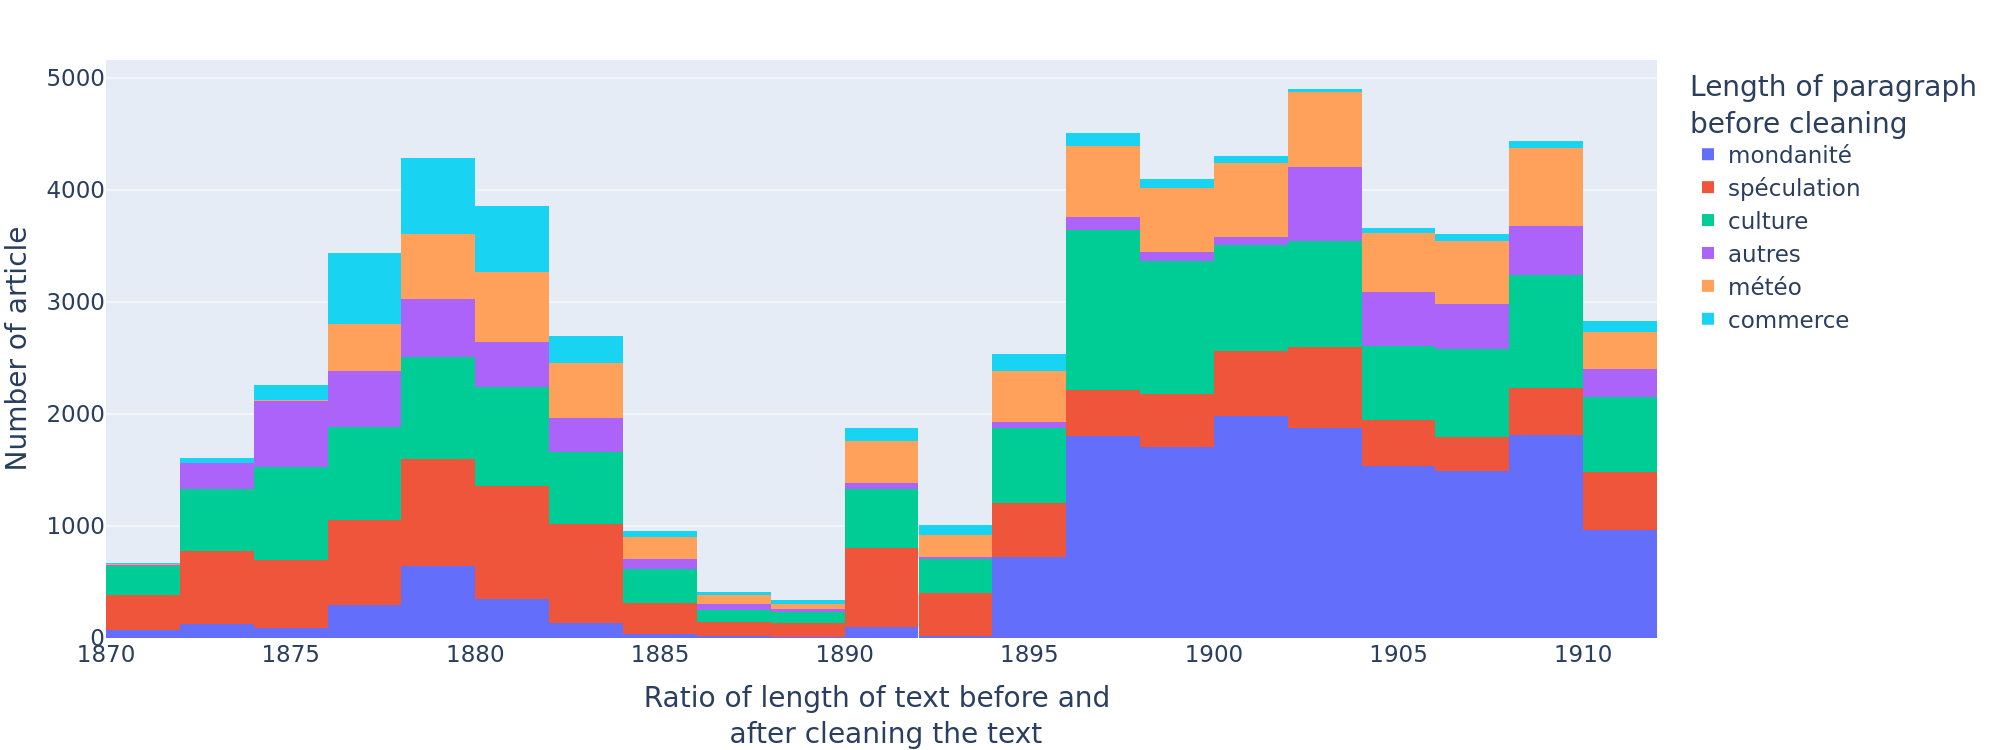

In [207]:
img = px.histogram(textDf[textDf.label != ''], x = 'date', color='label', nbins = 40)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Year",
    yaxis_title="Number of headline",
    font_size = 23,
    legend_title="Type of headline",
)
Image(img.to_image(format="png", width=2000, height=750))

In [208]:
textDf.to_csv('data/le_figaro.csv',index=False)

In [209]:
textDf['headlineKw'] = textDf.headline.apply(textCleaner.getAlphaChar).str.lower()


In [212]:
textDf[textDf.label == '']

,date,pageNum,paragraphNum,content,headline,label,headlineKw
2,1870-01-01,0,9,Admbûstrateur . AUGUSTE DUNIONT ABOMMBHXins Pa...,,,
3,1870-01-01,0,13,m part ri pas demain à l'occasion du jour de l...,Le Figaro,,lefigaro
5,1870-01-01,0,20-21-22-23-24,"Notre éclectisme en roli tique qui, pour être ...",,,
6,1870-01-01,0,25-26,"fœil bravement fixé sur le couteau, gravi les ...",,,
7,1870-01-01,0,27-28,". Hier matii , lés gens dé Batignolles considé...",,,
...,...,...,...,...,...,...,...
923898,1910-12-31,4,36,"Mdcon. Ce matin, il avait été décidé de tenter...",Par dépêches de nos correspondants MORT DU FOU...,,pardepechesdenoscorrespondantsmortdufouparricide
923899,1910-12-31,4,37,"On se rappelle l'aventure, de M. Brunet, le ph...",LE PHARMACIEN SÉQUESTRÉ w,,lepharmaciensequestrew
923900,1910-12-31,4,38,"Rouen , On a trouvé cette nuit, sur une voie d...",UN CADAVRE SUR LA VOIE,,uncadavresurlavoie
923901,1910-12-31,4,39,"division de l'escadre américaine, sous les ord...",,,


In [137]:
mdCounts = textDf[textDf['content'].apply(textCleaner.getAlphaChar).str.lower().apply(lambda x : 'feuilleton' in x )].headline
mdCounts = mdCounts.str.lower().str.split().explode()
mdCounts = mdCounts[~mdCounts.isna()]
mdCounts =  mdCounts[(mdCounts.apply(len)>3)].apply(textCleaner.getAlphaChar).value_counts()
mdRatio = pd.Series({k:(v/hc[k], v) for  k,v in mdCounts[mdCounts>10].to_dict().items()})

In [138]:
mdRatio.sort_values(ascending=False).iloc[0:60]

recevront            (0.9615384615384616, 25)
mmaire                           (0.9375, 15)
emoires                           (0.875, 14)
sommaieb                           (0.76, 19)
sommai               (0.6666666666666666, 14)
sommaire           (0.6177474402730375, 2353)
renvoyer            (0.6019736842105263, 183)
remettre             (0.5813953488372093, 50)
wolff                (0.5652173913043478, 13)
oblige              (0.5572354211663066, 258)
matieres            (0.5103806228373703, 295)
labondance          (0.5076660988074957, 298)
pages               (0.47058823529411764, 56)
sommaibb             (0.4411764705882353, 15)
troi                (0.39285714285714285, 11)
ils                 (0.36363636363636365, 12)
romanesques                        (0.32, 16)
seguy               (0.31521739130434784, 29)
ifr                 (0.30952380952380953, 26)
pelerinages          (0.2807017543859649, 16)
gares                (0.2619047619047619, 11)
tableau             (0.25757575757

In [148]:
textDf[textDf['headline'].str.lower().apply(lambda x : ('departements' in unidecode(x)))]

,date,pageNum,paragraphNum,content,headline,headlineKw
635,1870-01-12,0,3-4-5,"Nous avions, prête à passer aujourd'hui,une G ...",Administrateur AUGUSTE DUHIONT ABONNEMENTS Par...,
1027,1870-01-18,0,14-15-16,Eclxqs de Paris Par'suite dés derniers événeme...,ABONNEMENTS Paris : 3 mois Départements : 3 mo...,
1678,1870-01-30,0,6-7,il ne nous reste plus qu'un très petit nombre ...,ABONNEMENTS ' Paris : 3 mois 13 tr. S Départem...,
1749,1870-01-31,0,8,Il ne nous reste plus qu'un très petit ji nmlv...,ABONNEMENTS : Paris : 3 mois fr o. Département...,
1822,1870-02-01,0,7-8,Pétris D'après nos informations xi aurait ete ...,ABONNEMENTS Paris : 3 mois Départements : 3 mo...,
...,...,...,...,...,...,...
896556,1910-12-17,4,25,A Cherbourg La Chambre de commercé de Cherbour...,LES DÉPARTEMENTS,
896660,1910-12-18,4,7-8,"Coi'beîl. La péniche Vega chargée do sa ble, d...",DEPARTEMENTS NAUFRAGES DE PÉNICHES,
896858,1910-12-20,4,15,Les bateaux de pommes C'est une des plus vieil...,LES DÉPARTEMENTS,
897481,1910-12-28,4,22,Une réclamation des Cettois La réponse du P. L...,LES DÉPARTEMENTS,


In [129]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss

# set space between word and punctuation
textDf['raw_article'] = textDf.content.str.replace('(?<=\w)(?=[\!,\.:;\?]\W)',' ',regex=True)
textDf['raw_article'] = textDf.raw_article.str.replace('(?<=\W[\!,\.:;\?])(?=\w)',' ',regex=True)

# uniformize digits
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('\d','$',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>50].copy()

raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=25, threshold=10)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=20, threshold=10)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
textDf["nGram"] = raw_articles
textDf["nGram"] = textDf["nGram"].apply(' '.join)
textDf.to_csv('data/le_figaro_word2vec.csv',index=False)

cb = callback()
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 1e-4,
                 sg = 1,
                 hs=0,
                 negative = 15,
                 epochs = 15,
                 workers = 25,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD.model") 

Loss after epoch 0: 77115936.0


KeyboardInterrupt: 

In [142]:
test = textDf.sample(100000)
test.headlines = test.headlines.apply(lambda hls : hls & filteredHealines)

In [143]:
test = test[test.headlines.apply(len)>0]


In [175]:
test[test.headlines.apply(lambda x : 'offres' in x)]

,date,pageNum,paragraphNum,content,headlines,fullContent
3127555,1894-06-10,2,32,". OFFRES ET DEMANDES D'EMPLOI, GENS DE MAISON...",{offres},offresetdemandesdemploigensdemaisondanslenumér...
1328328,1885-05-20,5,62,Offres et Demandes de Capitaux ALGERIE. EXPLOI...,{offres},offresetdemandesdecapitauxalgerieexploitationv...
2444230,1878-04-25,2,80,"OFFRES ET DEMANDES D'EMPLOI TTNE j DAME, veuve...",{offres},offresetdemandesdemploittnejdameveuveubonmusic...
3352160,1897-02-06,3,44,OFFRES ET DEMANDES DE LOCATIONS. Dans le numér...,{offres},offresetdemandesdelocationsdanslenumérodudiman...
2239076,1876-01-04,2,63,OFFRES ET DESSALES . D'EMPLOI. ON dem un cjiof...,{offres},offresetdessalesdemploiondemuncjiofdepersonnel...
...,...,...,...,...,...,...
2733554,1882-04-26,4,121,offres,{offres},offres
2305365,1880-11-24,5,60,"OFFRES El DEMANDES DK CAPITAUX JRETS D'ARGENT,...",{offres},offreseldemandesdkcapitauxjretsdargentpariscla...
640524,1877-08-17,2,44,OFFRES ET DEMANDES D'EMPLOI HETZEL r. Montmart...,{offres},offresetdemandesdemploihetzelrmontmartreldamed...
2298199,1880-06-12,2,44,OFFRES ET. DEMANDES DE CAPITAUX HRETS D'ARGENT...,{offres},offresetdemandesdecapitauxhretsdargentpariscla...
